In [1]:
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import requests
import torch
import matplotlib.pyplot as plt

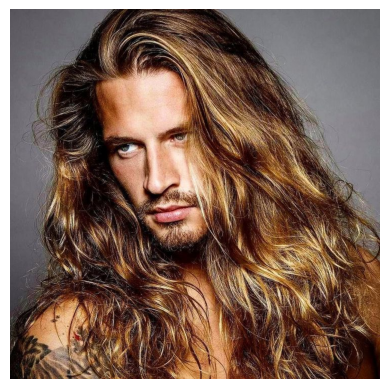

In [2]:
# load image
image = Image.open("default_images/makeup_hair_bias/man_with_long_hair_1.png")
plt.imshow(image)
plt.axis('off')
plt.show()

In [3]:
# Load CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", use_fast = False)

In [4]:
# Define candidate scene labels
texts = ["male", "female"]

# Preprocess and forward pass
inputs = processor(text=texts, images=image, return_tensors="pt", padding=True)
outputs = model(**inputs)

# Get probabilities
probs = outputs.logits_per_image.softmax(dim=1)

# Print result
for label, prob in zip(texts, probs[0]):
    print(f"{label}: {prob.item():.4f}")

male: 0.9885
female: 0.0115


In [5]:
import cv2
import os
import numpy as np
from PIL import Image

In [6]:
def analyze_with_opencv(image_path):
    # Path to the Caffe model files.
    gender_proto = "./models/gender_deploy.prototxt"
    gender_model = "./models/gender_net.caffemodel"

    net = cv2.dnn.readNetFromCaffe(gender_proto, gender_model)
    # The expected labels (this ordering may vary depending on the trained model)
    gender_list = ["Male", "Female"]

    # Load image
    image = Image.open(image_path).convert("RGB")
    cv_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(cv_image, cv2.COLOR_BGR2GRAY)

    # Use Haar cascades for face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    results = []
    for (x, y, w, h) in faces:
        face_img = cv_image[y:y+h, x:x+w]
        # Preprocess face region: resize to the network input size (227,227)
        blob = cv2.dnn.blobFromImage(face_img, 1.0, (227, 227),
                                     (78.4263377603, 87.7689143744, 114.895847746),
                                     swapRB=False)
        net.setInput(blob)
        preds = net.forward()
        results = {label: float(prob) for label, prob in zip(gender_list, preds[0])}
        # Get the label with the highest probability
        most_likely = max(results, key=results.get)
        # print(results)
        return results, most_likely

In [7]:
test_image_path = "default_images/makeup_hair_bias/man_with_long_hair_1.png"
results, most_likely = analyze_with_opencv(test_image_path)
print(f"Results: {results}")
print(f"Most likely: {most_likely}")



Results: {'Male': 0.006300437729805708, 'Female': 0.9936995506286621}
Most likely: Female
